# Ensemble Learning
A group of predictors is called an _ensemble_  
Random Forest is an ensemble of decision trees. Despite its simplicity its one of the most powerful machine learning algo.  
An ensemble learning algo is call _Ensemble method_

ex: an ensemble of decision tree classifiers are trained on different subsets of training data, then while prediction, each one predicts a class and then the prediction with most votes be the final prediction

### Why ensemble is better than one single expert algorithm with high accuracy?   
_The law of large numbers_ : as we increase the number of trials of an experiment, the ratio of outcomes starts to match the original probability despite the factor of randomness.  
ex: lets say we have a biased coin 51% head, 49% tails. the first 1000 may get 510 heads,490 tails, but still practically there is randomness and hence the probability that we will get _more number of heads than tails_ is about 75%, but as we increase the trails, this probability of _getting more number of heads than tails_ increases, at 10000 trails it becomes _97%_ 

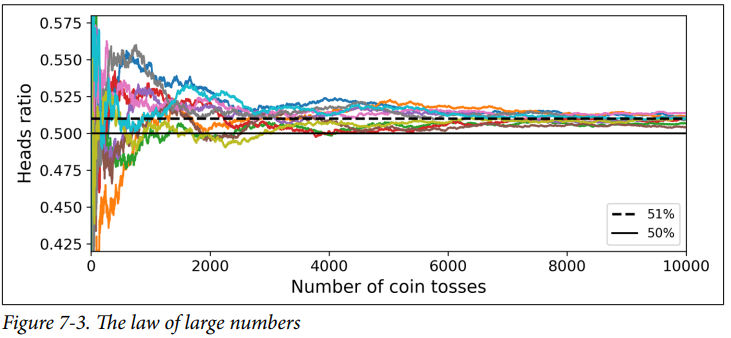

similarily, if we have 1000 weak classifiers with accuracy only 51% (meaning that they are correct about 51% of times). After ensembling them, we can get about 75% of accuracy. 97% accuracy if we have 10000 classifiers  

(This is just ex we are not training 10000 classifiers ever)

### The problem with ensemble
Ensemble methods works best when predictors are _independent_ from each other (being independent means that the errors of each base learner (predictor) are different and not correlated to each other)

Either the datasets on which each model is trained is different or each model itself is different fundamentally

why??   
If we have similar or correlated errors in ensemble, they will combine and error may increase in final model  
If we have different or independent errors in ensemble, they will cancel each oterh out and lead to more accurate overall model

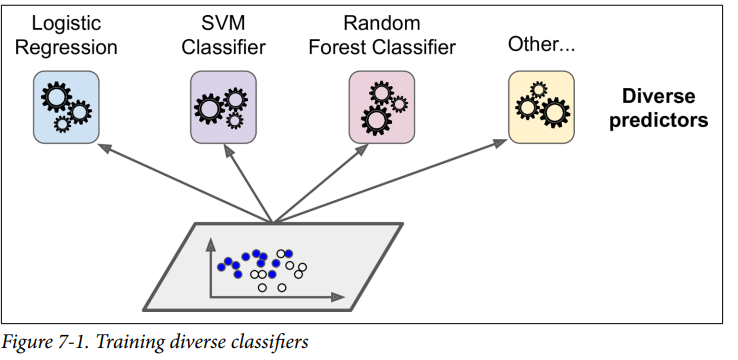

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Make moons dataset is used for classification problems
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

x,y = make_moons(n_samples=500,noise=0.3,random_state=42)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr',LogisticRegression(random_state=42)),
        ('svc',SVC(random_state=42)),
        ('rf',RandomForestClassifier(random_state=42))
    ],
    voting='hard'   #Two types of voting - Hard or soft 
)

voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))])

In [29]:
from sklearn.metrics import accuracy_score
for name, clf in zip([name for name, _ in voting_clf.estimators], voting_clf.estimators_):
    print(name, "=", accuracy_score(y_test,y_pred=clf.predict(x_test)))
print('ensemble score',accuracy_score(y_test,voting_clf.predict(x_test)))

lr = 0.864
svc = 0.896
rf = 0.896
ensemble score 0.912


(These are only 2-3 model ensemble, and data is not so complex, additionally these models work great individually so ensemble doesnt really help much) (We will see complex things soon)